In [13]:
# Basic imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import zipfile
import shutil

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import v2

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# For deployment
import gradio as gr


In [14]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [15]:
# Define data directory and output directory
DATA_DIR = r"C:\Users\praneethan\OneDrive\Desktop\Project"
OUTPUT_DIR = r"C:\Users\praneethan\OneDrive\Desktop\Project\results"
CLASSES = ["normal", "benign", "malignant"]
NUM_CLASSES = len(CLASSES)

# Create output folder if not exists
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [16]:
# Count total images per class (excluding masks)
for cls in CLASSES:
    folder = os.path.join(DATA_DIR, cls)
    count = len([img for img in os.listdir(folder) if "_mask" not in img])
    print(f"{cls.capitalize()}: {count} images")


Normal: 133 images
Benign: 437 images
Malignant: 210 images


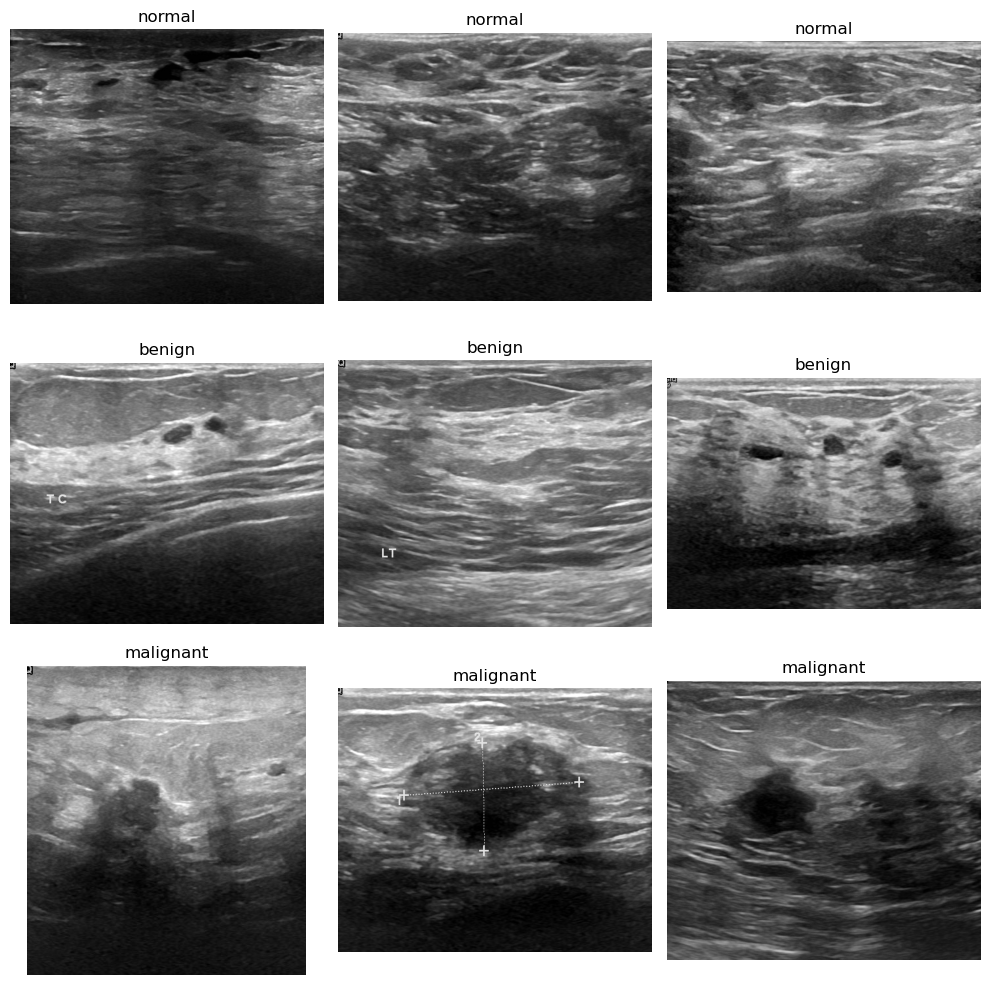

In [17]:
# Display random 3 images per class
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, cls in enumerate(CLASSES):
    folder = os.path.join(DATA_DIR, cls)
    images = [img for img in os.listdir(folder) if "_mask" not in img]
    samples = random.sample(images, 3)
    for j, img_name in enumerate(samples):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path).convert("L")
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")
        axs[i, j].set_title(f"{cls}")
plt.tight_layout()
plt.show()


In [18]:
# Custom PyTorch dataset class
class BreastDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)

        return image, label


In [19]:
# Load image paths and labels
image_paths = []
image_labels = []

for label, cls in enumerate(CLASSES):
    folder = os.path.join(DATA_DIR, cls)
    for img_name in os.listdir(folder):
        if "_mask" not in img_name:
            img_path = os.path.join(folder, img_name)
            image_paths.append(img_path)
            image_labels.append(label)

# Split into train and test
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.2, stratify=image_labels, random_state=42
)

# Apply transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create datasets
train_dataset = BreastDataset(train_imgs, train_labels, transform=train_transform)
test_dataset = BreastDataset(test_imgs, test_labels, transform=test_transform)


In [20]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [21]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
print(model)


CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [22]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train loop
EPOCHS = 10
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.4475


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.9651


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.9014


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.8682


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.8178


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.8033


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.7811


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.7736


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.7432


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.7303


In [23]:
# Evaluate the model
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print metrics
print(classification_report(y_true, y_pred, target_names=CLASSES))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


              precision    recall  f1-score   support

      normal       0.67      0.15      0.24        27
      benign       0.64      0.80      0.71        87
   malignant       0.61      0.60      0.60        42

    accuracy                           0.63       156
   macro avg       0.64      0.52      0.52       156
weighted avg       0.64      0.63      0.60       156

Confusion Matrix:
[[ 4 23  0]
 [ 1 70 16]
 [ 1 16 25]]


In [24]:
# Define prediction function
def predict(img):
    img = img.convert("L")  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
    return CLASSES[predicted.item()]

# Create Gradio interface
interface = gr.Interface(fn=predict,
                         inputs=gr.Image(type="pil"),
                         outputs=gr.Label(),
                         title="Breast Ultrasound Classifier")

# Launch the app
interface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://67c05e538db24f4685.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio\flagged\dataset1.csv
